# 2 - Models and Training
In this notebook we show how to load the dataset, load the different models (both learned and model based as a TF-graph), and train the models on the dataset.

In [1]:
import os

# because of the large (sparse) matrices, the gpu memory can get maxed out pretty quickly, resulting in errors like: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.
# to prevent this, you can disable/enable gpu completely by (un)commenting the following line
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


from src.config.config import DatasetConfig, ModelConfig
from src.data.load import load_datasets
import matplotlib.pyplot as plt

from src.models.load import load_model
from src.visualisation.visualise import plot_poloidal



## Load dataset and visualise sample

In [2]:
# define data configurations
data_config = DatasetConfig(shot_no=65903, batch_size=1)

# load datasets
train_ds, val_ds, test_ds = load_datasets(data_config)

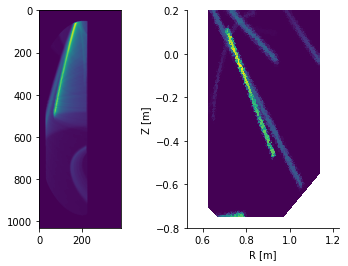

In [3]:
sample_image, sample_inversion = train_ds.__iter__().next()

input_shape = (sample_image.shape[1], sample_image.shape[2])
output_shape = (sample_inversion.shape[1], sample_inversion.shape[2])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(sample_image[0])
plot_poloidal(sample_inversion, axs[1])

## Load model architectures (model-based)

In [4]:
sirt_model_config = ModelConfig(name="sirt", shot_no=65903, n_iterations=100, mu=2.)
gd_model_config = ModelConfig(name="gradient descent", shot_no=65903, n_iterations=100, mu=0.034)

sirt_model_config.set_shape_from_ds(train_ds)
gd_model_config.set_shape_from_ds(train_ds)

In [5]:
sirt_model = load_model(sirt_model_config)
sirt_model.compile(metrics=['mse', 'mae'])

In [6]:
gd_model = load_model(gd_model_config)
gd_model.compile(metrics=['mse', 'mae'])

In [7]:
sirt_inversion_est = sirt_model(sample_image)
gd_inversion_est = gd_model(sample_image)

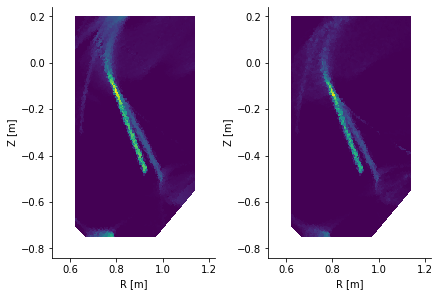

In [8]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)
plot_poloidal(sirt_inversion_est, axs[0])
plot_poloidal(gd_inversion_est, axs[1])

## Load model architectures (learned)

In [9]:
unet_sirt_informed_config = ModelConfig(name="unet sirt", shot_no=65903)
unet_sirt_informed_config.set_shape_from_ds(train_ds)

unet_sirt_informed = load_model(unet_sirt_informed_config)
unet_sirt_informed.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

unet_sirt_informed.fit(train_ds.take(10))

ValueError: Exception encountered when calling layer "unet_base" (type UnetBase).

in user code:

    File "D:\programming\mantis_ml_inversion_reproduction\src\models\unet.py", line 48, in call  *
        x = self.decoder(x, skips_rev)
    File "D:\programming\mantis_ml_inversion_reproduction\venv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\loekv\AppData\Local\Temp\__autograph_generated_fileoowpcs32.py", line 24, in tf__call
        ag__.for_stmt(ag__.converted_call(ag__.ld(zip), (ag__.ld(self).decoder_blocks, ag__.ld(skips)), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': '(d_block, skip)'})
    File "C:\Users\loekv\AppData\Local\Temp\__autograph_generated_fileoowpcs32.py", line 21, in loop_body
        x = ag__.converted_call(ag__.ld(d_block), (ag__.ld(x), ag__.ld(skip)), None, fscope)
    File "C:\Users\loekv\AppData\Local\Temp\__autograph_generated_filedvm4kk02.py", line 11, in tf__call
        x = ag__.converted_call(ag__.ld(self).concatenate, ([ag__.ld(x), ag__.ld(skip)],), None, fscope)

    ValueError: Exception encountered when calling layer "decoder" (type Decoder).
    
    in user code:
    
        File "D:\programming\mantis_ml_inversion_reproduction\src\models\unet.py", line 94, in call  *
            x = d_block(x, skip)
        File "D:\programming\mantis_ml_inversion_reproduction\venv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\loekv\AppData\Local\Temp\__autograph_generated_filedvm4kk02.py", line 11, in tf__call
            x = ag__.converted_call(ag__.ld(self).concatenate, ([ag__.ld(x), ag__.ld(skip)],), None, fscope)
    
        ValueError: Exception encountered when calling layer "decode_block" (type DecodeBlock).
        
        in user code:
        
            File "D:\programming\mantis_ml_inversion_reproduction\src\models\unet.py", line 154, in call  *
                x = self.concatenate([x, skip])
            File "D:\programming\mantis_ml_inversion_reproduction\venv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "D:\programming\mantis_ml_inversion_reproduction\venv\lib\site-packages\keras\layers\merging\concatenate.py", line 123, in build
                raise ValueError(err_msg)
        
            ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 8, 8, 128), (None, 4, 4, 128)]
        
        
        Call arguments received by layer "decode_block" (type DecodeBlock):
          • x=tf.Tensor(shape=(None, 4, 4, 128), dtype=float32)
          • skip=tf.Tensor(shape=(None, 4, 4, 128), dtype=float32)
    
    
    Call arguments received by layer "decoder" (type Decoder):
      • x=tf.Tensor(shape=(None, 4, 4, 128), dtype=float32)
      • skips=['tf.Tensor(shape=(None, 4, 4, 128), dtype=float32)', 'tf.Tensor(shape=(None, 8, 8, 128), dtype=float32)', 'tf.Tensor(shape=(None, 16, 16, 128), dtype=float32)', 'tf.Tensor(shape=(None, 32, 32, 64), dtype=float32)', 'tf.Tensor(shape=(None, 64, 64, 64), dtype=float32)', 'tf.Tensor(shape=(None, 128, 128, 64), dtype=float32)']


Call arguments received by layer "unet_base" (type UnetBase):
  • x=tf.Tensor(shape=(None, 256, 256, 1), dtype=float32)

In [ ]:
learned_proximal_sirt_config = ModelConfig(name="learned proximal sirt", shot_no=65903, n_iterations=5, encoder_filters=[8, 8, 16, 32], decoder_filters=[32, 16, 8, 8], bottleneck_filters=[32])
learned_proximal_sirt_config.set_shape_from_ds(train_ds)

learned_proximal_sirt = load_model(learned_proximal_sirt_config)
learned_proximal_sirt.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

learned_proximal_sirt.fit(train_ds.take(10))